In [1]:
# Data manipulation
import pandas as pd
import numpy as np
# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 18
%matplotlib inline

MAX_EVALS = 20
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer



In [2]:
import json
import shlex
import subprocess
import logging
from pprint import pprint
import re
import os


In [3]:
def runthebenchmark(hyperparameters):
    os.chdir('/home/dsinghvi/project/progress/active/../')
    storeinfile(hyperparameters)
    out=subprocess.Popen(["python3","read_config_general.py","-n 16","-c400 400 800 4 4 8 1"], shell=False, stdout=subprocess.PIPE)
    logging.basicConfig(level=logging.DEBUG)
    output=out.stdout.read().decode('utf-8')
    print("output"+output)
    if len(output.split(" ")) > 5:
        values = output.split(" ")
        value = float(float(values[6])*1024)/float(values[5]) + float(float(values[3])*1024)/float(values[2])
        value = float(value)
        print(value)
        return float(value**3),output
    return (0,0);

In [4]:
def storeinfile(hyperparameters):
    data={"mpi": {"romio_ds_read": "enable", "romio_ds_write": "disable"}, "lfs": {"setstripe": {"size": "16777216", "count": 4}}}
    data["lfs"]["setstripe"]["size"] = int(hyperparameters["setstripe-size"])
    data["lfs"]["setstripe"]["count"] = int(hyperparameters["setstripe-count"])

    data["mpi"]["romio_ds_read"] = hyperparameters["romio_ds_read"]
    data["mpi"]["romio_ds_write"] = hyperparameters["romio_ds_write"]
    data["mpi"]["romio_cb_read"] = hyperparameters["romio_cb_read"]
    data["mpi"]["romio_cb_write"] = hyperparameters["romio_cb_write"]
    data["mpi"]["cb_buffer_size"] = str(int(hyperparameters["cb_buffer_size"]))
    with open("confex.json","w") as fp:
        json.dump(data,fp)
    print(data)


In [5]:
def objective(hyperparameters):
    global ITERATION
    ITERATION += 1
    start = timer()
    result=0
    while(result == 0):
        print("rerun")
        result,output = runthebenchmark(hyperparameters)
        print(result)
    run_time = timer() - start
    print({'loss': result, 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK})
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([float(result), hyperparameters, ITERATION, run_time, output])
    return {'loss': float(result), 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK}


In [6]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

space = {
    'romio_ds_read' : hp.choice('romio_ds_read',['enable','disable']),
    'romio_ds_write' : hp.choice('romio_ds_write',['enable','disable']),
    'romio_cb_read' : hp.choice('romio_cb_read',['enable','disable']),
    'romio_cb_write' : hp.choice('romio_cb_write',['enable','disable']),
    'cb_buffer_size' : 1048576*hp.quniform('cb_buffer_size',1,512,1),
    'setstripe-size' : 65536*(hp.qloguniform('setstripe-size',0,3,1)),
    'setstripe-count' : hp.quniform('setstripe-count',0,20,1)
    
}

In [7]:
x = sample(space)
params = x
print(x)

cb_buffer_size_dist = []
for _ in range(1000):
    cb_buffer_size_dist.append(sample(space)['cb_buffer_size'])
    
setstripe_size_dist = []
for _ in range(1000):
    setstripe_size_dist.append(sample(space)['setstripe-size'])
    
setstripe_count_dist = []
for _ in range(1000):
    setstripe_count_dist.append(sample(space)['setstripe-count']) 
    
romio_ds_read_dist = []
for _ in range(20):
    romio_ds_read_dist.append(sample(space)['romio_ds_read'])
    
romio_ds_write_dist = []
for _ in range(20):
    romio_ds_write_dist.append(sample(space)['romio_ds_write'])
    
romio_cb_read_dist = []
for _ in range(20):
    romio_cb_read_dist.append(sample(space)['romio_cb_read']) 
    
romio_cb_write_dist = []
for _ in range(20):
    romio_cb_write_dist.append(sample(space)['romio_cb_write']) 
    

{'cb_buffer_size': 304087040.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 16.0, 'setstripe-size': 851968.0}


In [8]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest


from hyperopt import Trials

# Record results
bayes_trials = Trials()

In [9]:
# File to save first results
print(os.getcwd())
out_file = '/home/dsinghvi/project/progress/active/result/gbm_trials-448.csv'

/home/dsinghvi/project/progress/active


In [10]:
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
writer.writerow(['loss', 'params', 'iteration', 'train_time', 'output'])
of_connection.close()

In [11]:
from hyperopt import fmin


ITERATION = 20

best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = bayes_trials, max_evals = MAX_EVALS)

rerun                                               
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '154140672'}, 'lfs': {'setstripe': {'size': 458752, 'count': 18}}}
outputS3D-IO 400-400-800-4-4-8-1 1992.18 15.26 7.84 1038.19 45.78 45.15 0.10 0.38 458752 18 enable disable enable enable 154140672 

52.99806733448271                                   
148860.71402157476                                  
{'loss': 148860.71402157476, 'hyperparameters': {'cb_buffer_size': 154140672.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 18.0, 'setstripe-size': 458752.0}, 'iteration': 21, 'iteration_time': 58.958154413849115, 'status': 'ok'}
  5%|▌         | 1/20 [00:58<18:40, 58.97s/it, best loss: 148860.71402157476]

INFO:hyperopt.tpe:tpe_transform took 0.011510 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 148860.714022


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '13631488'}, 'lfs': {'setstripe': {'size': 1179648, 'count': 12}}}
outputS3D-IO 400-400-800-4-4-8-1 1025.41 15.26 15.24 401.70 45.78 116.69 0.12 0.06 1179648 12 enable enable enable disable 13631488 

131.93983809707507                                                           
2296824.6500965618                                                           
{'loss': 2296824.6500965618, 'hyperparameters': {'cb_buffer_size': 13631488.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 12.0, 'setstripe-size': 1179648.0}, 'iteration': 22, 'iteration_time': 137.96916912216693, 'status': 'ok'}
 10%|█         | 2/20 [03:16<24:48, 82.68s/it, best loss: 148860.71402157476]

INFO:hyperopt.tpe:tpe_transform took 0.010178 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 148860.714022


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '528482304'}, 'lfs': {'setstripe': {'size': 327680, 'count': 6}}}
outputS3D-IO 400-400-800-4-4-8-1 2492.51 15.26 6.27 936.77 45.78 50.04 0.18 1.31 327680 6 disable enable enable enable 528482304 

56.312213524366285                                                           
178569.71145481057                                                           
{'loss': 178569.71145481057, 'hyperparameters': {'cb_buffer_size': 528482304.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 6.0, 'setstripe-size': 327680.0}, 'iteration': 23, 'iteration_time': 62.06079716049135, 'status': 'ok'}
 15%|█▌        | 3/20 [04:19<21:40, 76.51s/it, best loss: 148860.71402157476]

INFO:hyperopt.tpe:tpe_transform took 0.010283 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 148860.714022


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '386924544'}, 'lfs': {'setstripe': {'size': 1114112, 'count': 14}}}
outputS3D-IO 400-400-800-4-4-8-1 2032.14 15.26 7.69 1267.54 45.78 36.98 0.84 0.69 1114112 14 enable enable disable disable 386924544 

44.67356523190902                                                            
89156.25955287564                                                            
{'loss': 89156.25955287564, 'hyperparameters': {'cb_buffer_size': 386924544.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 14.0, 'setstripe-size': 1114112.0}, 'iteration': 24, 'iteration_time': 51.283764911815524, 'status': 'ok'}
 20%|██        | 4/20 [05:10<18:23, 68.95s/it, best loss: 89156.25955287564] 

INFO:hyperopt.tpe:tpe_transform took 0.009616 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 89156.259553


rerun                                                                       
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '526385152'}, 'lfs': {'setstripe': {'size': 393216, 'count': 11}}}
outputS3D-IO 400-400-800-4-4-8-1 2226.02 15.26 7.02 1132.98 45.78 41.37 0.11 0.97 393216 11 disable enable enable enable 526385152 

48.39628733827681                                                           
113353.81460282602                                                          
{'loss': 113353.81460282602, 'hyperparameters': {'cb_buffer_size': 526385152.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 11.0, 'setstripe-size': 393216.0}, 'iteration': 25, 'iteration_time': 54.41620020754635, 'status': 'ok'}
 25%|██▌       | 5/20 [06:04<16:08, 64.60s/it, best loss: 89156.25955287564]

INFO:hyperopt.tpe:tpe_transform took 0.009580 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 89156.259553


rerun                                                                       
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '289406976'}, 'lfs': {'setstripe': {'size': 131072, 'count': 18}}}
outputS3D-IO 400-400-800-4-4-8-1 838.44 15.26 18.64 1193.19 45.78 39.29 0.14 0.50 131072 18 disable disable disable enable 289406976 

57.925841348498196                                                          
194364.54739518097                                                          
{'loss': 194364.54739518097, 'hyperparameters': {'cb_buffer_size': 289406976.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 18.0, 'setstripe-size': 131072.0}, 'iteration': 26, 'iteration_time': 63.69619963504374, 'status': 'ok'}
 30%|███       | 6/20 [07:08<15:00, 64.34s/it, best loss: 89156.25955287564]

INFO:hyperopt.tpe:tpe_transform took 0.010164 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 89156.259553


rerun                                                                       
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '158334976'}, 'lfs': {'setstripe': {'size': 327680, 'count': 14}}}
outputS3D-IO 400-400-800-4-4-8-1 2298.10 15.26 6.80 1014.93 45.78 46.19 0.11 0.32 327680 14 enable disable disable enable 158334976 

52.98875097145041                                                           
148782.22455495142                                                          
{'loss': 148782.22455495142, 'hyperparameters': {'cb_buffer_size': 158334976.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 14.0, 'setstripe-size': 327680.0}, 'iteration': 27, 'iteration_time': 59.035739501938224, 'status': 'ok'}
 35%|███▌      | 7/20 [08:07<13:35, 62.76s/it, best loss: 89156.25955287564]

INFO:hyperopt.tpe:tpe_transform took 0.010362 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 89156.259553


rerun                                                                       
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '2097152'}, 'lfs': {'setstripe': {'size': 131072, 'count': 18}}}
outputS3D-IO 400-400-800-4-4-8-1 1961.38 15.26 7.97 383.44 45.78 122.25 0.08 0.05 131072 18 enable disable enable disable 2097152 

130.22525538139385                                                          
2208440.2478609937                                                          
{'loss': 2208440.2478609937, 'hyperparameters': {'cb_buffer_size': 2097152.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 18.0, 'setstripe-size': 131072.0}, 'iteration': 28, 'iteration_time': 135.91695194598287, 'status': 'ok'}
 40%|████      | 8/20 [10:23<16:56, 84.71s/it, best loss: 89156.25955287564]

INFO:hyperopt.tpe:tpe_transform took 0.010048 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 89156.259553


rerun                                                                       
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '40894464'}, 'lfs': {'setstripe': {'size': 196608, 'count': 2}}}
outputS3D-IO 400-400-800-4-4-8-1 1824.30 15.26 8.57 456.98 45.78 102.58 0.11 0.06 196608 2 disable enable enable enable 40894464 

111.14935418595476                                                          
1373159.010229104                                                           
{'loss': 1373159.010229104, 'hyperparameters': {'cb_buffer_size': 40894464.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 2.0, 'setstripe-size': 196608.0}, 'iteration': 29, 'iteration_time': 116.85553599335253, 'status': 'ok'}
 45%|████▌     | 9/20 [12:20<17:18, 94.37s/it, best loss: 89156.25955287564]

INFO:hyperopt.tpe:tpe_transform took 0.009726 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 89156.259553


rerun                                                                       
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '256901120'}, 'lfs': {'setstripe': {'size': 131072, 'count': 10}}}
outputS3D-IO 400-400-800-4-4-8-1 1182.71 15.26 13.21 1172.06 45.78 39.99 1.19 0.72 131072 10 disable disable disable enable 256901120 

53.20909315169301                                                           
150645.98860228583                                                          
{'loss': 150645.98860228583, 'hyperparameters': {'cb_buffer_size': 256901120.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 10.0, 'setstripe-size': 131072.0}, 'iteration': 30, 'iteration_time': 60.196868592873216, 'status': 'ok'}
 50%|█████     | 10/20 [13:20<14:01, 84.13s/it, best loss: 89156.25955287564]

INFO:hyperopt.tpe:tpe_transform took 0.010130 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 89156.259553


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '532676608'}, 'lfs': {'setstripe': {'size': 262144, 'count': 15}}}
outputS3D-IO 400-400-800-4-4-8-1 543.78 15.26 28.73 1239.88 45.78 37.81 1.82 0.99 262144 15 enable enable disable enable 532676608 

66.54540548904328                                                            
294682.4196662333                                                            
{'loss': 294682.4196662333, 'hyperparameters': {'cb_buffer_size': 532676608.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 15.0, 'setstripe-size': 262144.0}, 'iteration': 31, 'iteration_time': 74.32076004799455, 'status': 'ok'}
 55%|█████▌    | 11/20 [14:35<12:10, 81.19s/it, best loss: 89156.25955287564]

INFO:hyperopt.tpe:tpe_transform took 0.010071 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 89156.259553


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '296747008'}, 'lfs': {'setstripe': {'size': 65536, 'count': 19}}}
outputS3D-IO 400-400-800-4-4-8-1 577.66 15.26 27.05 1171.50 45.78 40.01 0.11 0.55 65536 19 enable disable disable disable 296747008 

67.06690912601917                                                            
301664.96534270106                                                           
{'loss': 301664.96534270106, 'hyperparameters': {'cb_buffer_size': 296747008.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 19.0, 'setstripe-size': 65536.0}, 'iteration': 32, 'iteration_time': 72.77209740597755, 'status': 'ok'}
 60%|██████    | 12/20 [15:47<10:29, 78.68s/it, best loss: 89156.25955287564]

INFO:hyperopt.tpe:tpe_transform took 0.009759 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 89156.259553


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '59768832'}, 'lfs': {'setstripe': {'size': 65536, 'count': 14}}}
outputS3D-IO 400-400-800-4-4-8-1 716.99 15.26 21.79 725.82 45.78 64.58 0.11 0.07 65536 14 disable disable enable enable 59768832 

86.38147610939477                                                            
644557.7926268749                                                            
{'loss': 644557.7926268749, 'hyperparameters': {'cb_buffer_size': 59768832.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 14.0, 'setstripe-size': 65536.0}, 'iteration': 33, 'iteration_time': 92.3891158727929, 'status': 'ok'}
 65%|██████▌   | 13/20 [17:20<09:39, 82.80s/it, best loss: 89156.25955287564]

INFO:hyperopt.tpe:tpe_transform took 0.009802 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 89156.259553


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '446693376'}, 'lfs': {'setstripe': {'size': 131072, 'count': 6}}}
outputS3D-IO 400-400-800-4-4-8-1 643.15 15.26 24.29 1279.81 45.78 36.63 0.09 0.43 131072 6 disable disable enable disable 446693376 

60.92585325920214                                                            
226154.30561110235                                                           
{'loss': 226154.30561110235, 'hyperparameters': {'cb_buffer_size': 446693376.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 6.0, 'setstripe-size': 131072.0}, 'iteration': 34, 'iteration_time': 68.46005051396787, 'status': 'ok'}
 70%|███████   | 14/20 [18:28<07:51, 78.51s/it, best loss: 89156.25955287564]

INFO:hyperopt.tpe:tpe_transform took 0.009823 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 89156.259553


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '493879296'}, 'lfs': {'setstripe': {'size': 131072, 'count': 5}}}
outputS3D-IO 400-400-800-4-4-8-1 933.24 15.26 16.74 843.99 45.78 55.54 0.12 0.17 131072 5 enable enable enable enable 493879296 

72.28823962266841                                                            
377748.672288583                                                             
{'loss': 377748.672288583, 'hyperparameters': {'cb_buffer_size': 493879296.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 5.0, 'setstripe-size': 131072.0}, 'iteration': 35, 'iteration_time': 78.10921004787087, 'status': 'ok'}
 75%|███████▌  | 15/20 [19:46<06:32, 78.41s/it, best loss: 89156.25955287564]

INFO:hyperopt.tpe:tpe_transform took 0.010232 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 89156.259553


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '293601280'}, 'lfs': {'setstripe': {'size': 262144, 'count': 13}}}
outputS3D-IO 400-400-800-4-4-8-1 730.53 15.26 21.39 875.58 45.78 53.54 0.30 0.58 262144 13 disable enable enable enable 293601280 

74.93046879339934                                                            
420702.7483349147                                                            
{'loss': 420702.7483349147, 'hyperparameters': {'cb_buffer_size': 293601280.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 13.0, 'setstripe-size': 262144.0}, 'iteration': 36, 'iteration_time': 81.43759001046419, 'status': 'ok'}
 80%|████████  | 16/20 [21:08<05:17, 79.41s/it, best loss: 89156.25955287564]

INFO:hyperopt.tpe:tpe_transform took 0.011641 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 89156.259553


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '480247808'}, 'lfs': {'setstripe': {'size': 131072, 'count': 14}}}
outputS3D-IO 400-400-800-4-4-8-1 669.24 15.26 23.35 789.69 45.78 59.36 0.70 0.28 131072 14 disable disable disable disable 480247808 

82.71267838029868                                                            
565869.4562407401                                                            
{'loss': 565869.4562407401, 'hyperparameters': {'cb_buffer_size': 480247808.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 14.0, 'setstripe-size': 131072.0}, 'iteration': 37, 'iteration_time': 89.51322829350829, 'status': 'ok'}
 85%|████████▌ | 17/20 [22:38<04:07, 82.46s/it, best loss: 89156.25955287564]

INFO:hyperopt.tpe:tpe_transform took 0.010055 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 89156.259553


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '444596224'}, 'lfs': {'setstripe': {'size': 65536, 'count': 11}}}
outputS3D-IO 400-400-800-4-4-8-1 748.55 15.26 20.87 989.96 45.78 47.35 0.26 0.55 65536 11 disable enable enable disable 444596224 

68.2295013917556                                                             
317626.40025579487                                                           
{'loss': 317626.40025579487, 'hyperparameters': {'cb_buffer_size': 444596224.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 11.0, 'setstripe-size': 65536.0}, 'iteration': 38, 'iteration_time': 74.54206329211593, 'status': 'ok'}
 90%|█████████ | 18/20 [23:52<02:40, 80.09s/it, best loss: 89156.25955287564]

INFO:hyperopt.tpe:tpe_transform took 0.009616 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 89156.259553


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '66060288'}, 'lfs': {'setstripe': {'size': 786432, 'count': 18}}}
outputS3D-IO 400-400-800-4-4-8-1 1442.63 15.26 10.83 705.36 45.78 66.46 0.32 0.18 786432 18 disable enable enable enable 66060288 

77.29247344524589                                                            
461755.0100944128                                                            
{'loss': 461755.0100944128, 'hyperparameters': {'cb_buffer_size': 66060288.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 18.0, 'setstripe-size': 786432.0}, 'iteration': 39, 'iteration_time': 83.25799257028848, 'status': 'ok'}
 95%|█████████▌| 19/20 [25:16<01:21, 81.06s/it, best loss: 89156.25955287564]

INFO:hyperopt.tpe:tpe_transform took 0.009635 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 89156.259553


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '330301440'}, 'lfs': {'setstripe': {'size': 131072, 'count': 7}}}
outputS3D-IO 400-400-800-4-4-8-1                                             
 95%|█████████▌| 19/20 [26:46<01:21, 81.06s/it, best loss: 89156.25955287564]

INFO:hyperopt.fmin:job exception: 'int' object is not iterable


TypeError: 'int' object is not iterable

In [12]:
print(best)
d=  best
#print(bayes_trials.results)
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
#bayes_trials_results[:1]

NameError: name 'best' is not defined

In [13]:
results = pd.read_csv(out_file)

# Sort with best scores on top and reset index for slicing
results.sort_values('train_time', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()


,loss,params,iteration,train_time,output
0,89156.259553,"{'cb_buffer_size': 386924544.0, 'romio_cb_read...",24,51.283765,S3D-IO 400-400-800-4-4-8-1 2032.14 15.26 7.69 ...
1,113353.814603,"{'cb_buffer_size': 526385152.0, 'romio_cb_read...",25,54.416200,S3D-IO 400-400-800-4-4-8-1 2226.02 15.26 7.02 ...
2,148860.714022,"{'cb_buffer_size': 154140672.0, 'romio_cb_read...",21,58.958154,S3D-IO 400-400-800-4-4-8-1 1992.18 15.26 7.84 ...
3,148782.224555,"{'cb_buffer_size': 158334976.0, 'romio_cb_read...",27,59.035740,S3D-IO 400-400-800-4-4-8-1 2298.10 15.26 6.80 ...
4,150645.988602,"{'cb_buffer_size': 256901120.0, 'romio_cb_read...",30,60.196869,S3D-IO 400-400-800-4-4-8-1 1182.71 15.26 13.21...


In [14]:
type(results)

pandas.core.frame.DataFrame

In [15]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()
print(best_bayes_params)
print(results.loc[0,'output'])

{'cb_buffer_size': 386924544.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 14.0, 'setstripe-size': 1114112.0}
S3D-IO 400-400-800-4-4-8-1 2032.14 15.26 7.69 1267.54 45.78 36.98 0.84 0.69 1114112 14 enable enable disable disable 386924544 



In [16]:
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
bayes_params['train_time'] = results['train_time']    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']
bayes_params['output']=results['output']
bayes_params.head()

,cb_buffer_size,romio_cb_read,romio_cb_write,romio_ds_read,romio_ds_write,setstripe-count,setstripe-size,train_time,loss,iteration,output
0,3.86925e+08,disable,disable,enable,enable,14,1.11411e+06,51.283765,89156.259553,24,S3D-IO 400-400-800-4-4-8-1 2032.14 15.26 7.69 ...
1,5.26385e+08,enable,enable,disable,enable,11,393216,54.416200,113353.814603,25,S3D-IO 400-400-800-4-4-8-1 2226.02 15.26 7.02 ...
2,1.54141e+08,enable,enable,enable,disable,18,458752,58.958154,148860.714022,21,S3D-IO 400-400-800-4-4-8-1 1992.18 15.26 7.84 ...
3,1.58335e+08,disable,enable,enable,disable,14,327680,59.035740,148782.224555,27,S3D-IO 400-400-800-4-4-8-1 2298.10 15.26 6.80 ...
4,2.56901e+08,disable,enable,disable,disable,10,131072,60.196869,150645.988602,30,S3D-IO 400-400-800-4-4-8-1 1182.71 15.26 13.21...


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=18.0 to DejaVu Sans ('/home/dsinghvi/project/progress/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=21.599999999999998 to DejaVu Sans ('/home/dsinghvi/project/progress/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


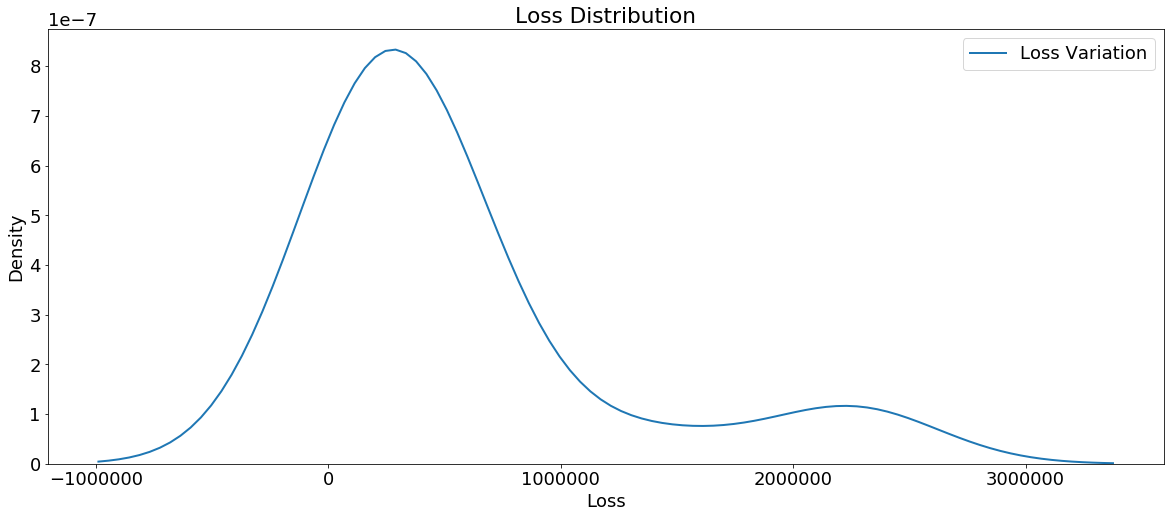

In [17]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(bayes_params['loss'], label = 'Loss Variation', linewidth = 2)
plt.legend()
plt.xlabel('Loss'); plt.ylabel('Density'); plt.title('Loss Distribution');


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


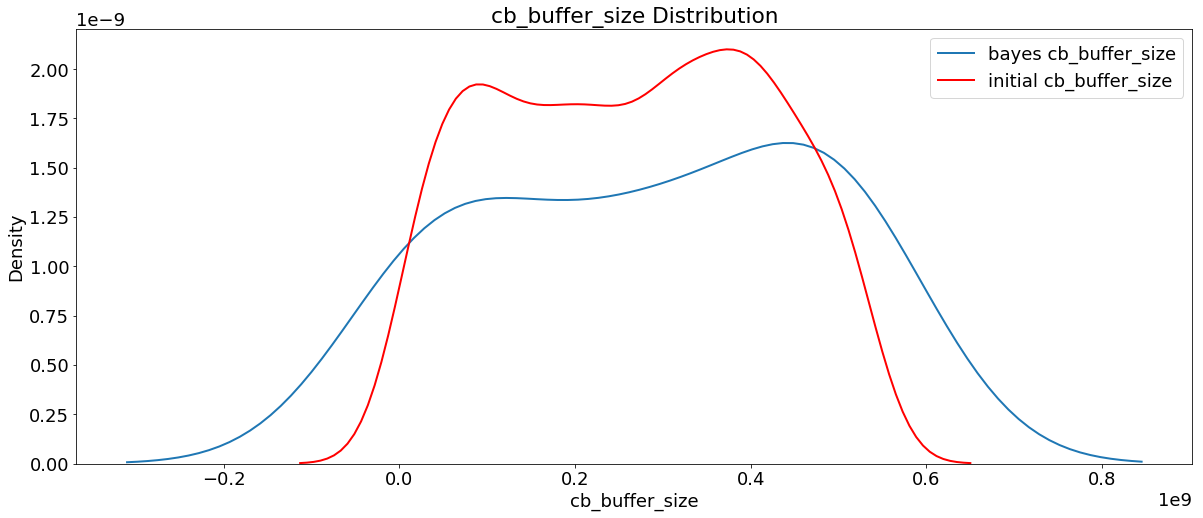

In [18]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18


sns.kdeplot(bayes_params['cb_buffer_size'], label = 'bayes cb_buffer_size', linewidth = 2)
sns.kdeplot(cb_buffer_size_dist,color="red",linewidth=2, label = 'initial cb_buffer_size')

plt.legend()
plt.xlabel('cb_buffer_size'); plt.ylabel('Density'); plt.title('cb_buffer_size Distribution');

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


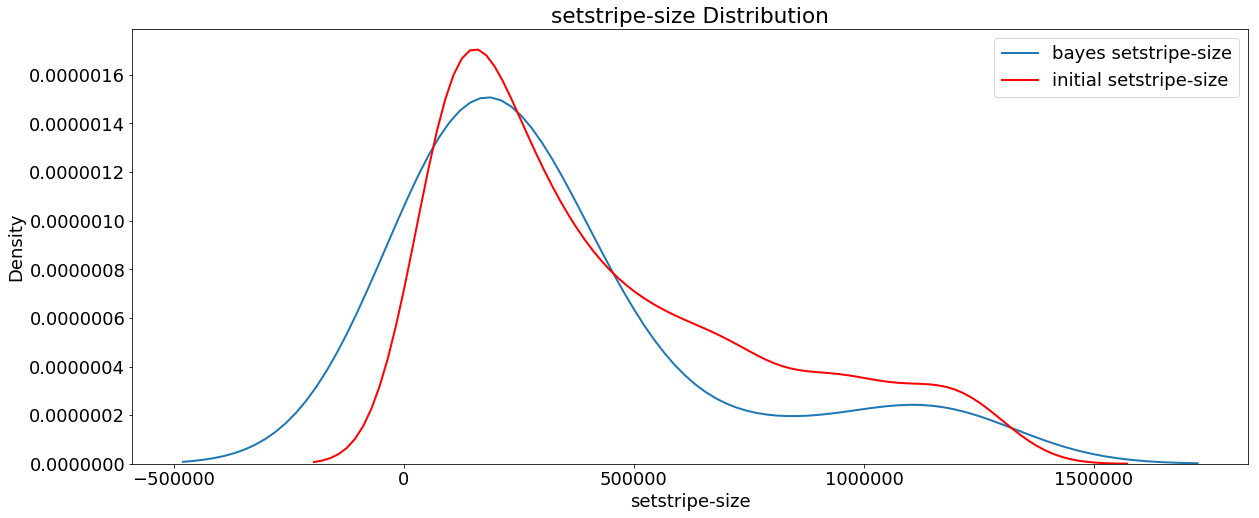

In [19]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(bayes_params['setstripe-size'], label = 'bayes setstripe-size', linewidth = 2)
sns.kdeplot(setstripe_size_dist,color="red",linewidth=2, label = 'initial setstripe-size')

plt.legend()
plt.xlabel('setstripe-size'); plt.ylabel('Density'); plt.title('setstripe-size Distribution');

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


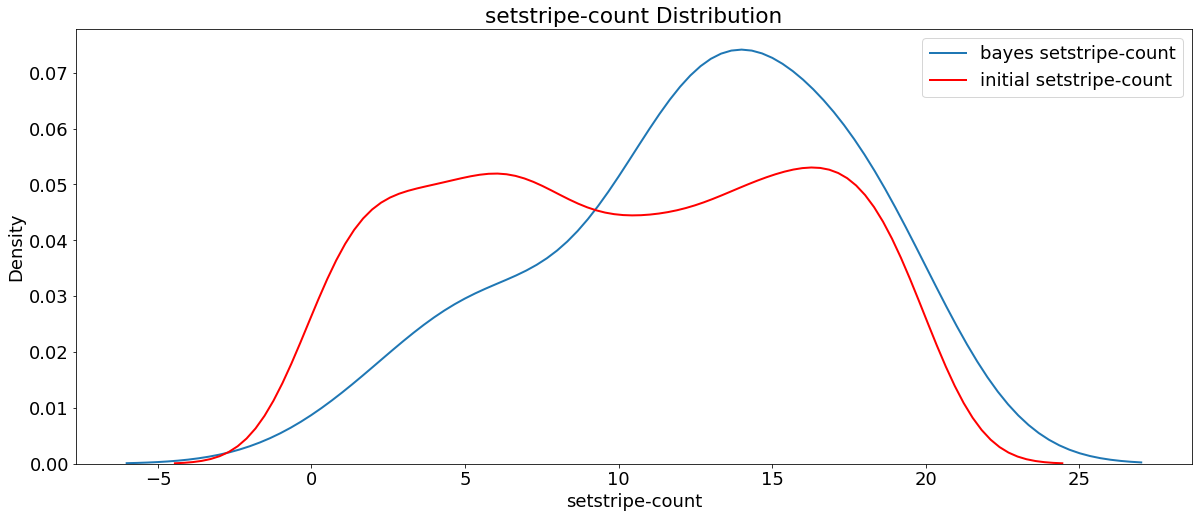

In [20]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(bayes_params['setstripe-count'], label = 'bayes setstripe-count', linewidth = 2)
sns.kdeplot(setstripe_count_dist,color="red",linewidth=2, label = 'initial setstripe-count')

plt.legend()
plt.xlabel('setstripe-count'); plt.ylabel('Density'); plt.title('setstripe-count Distribution');

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


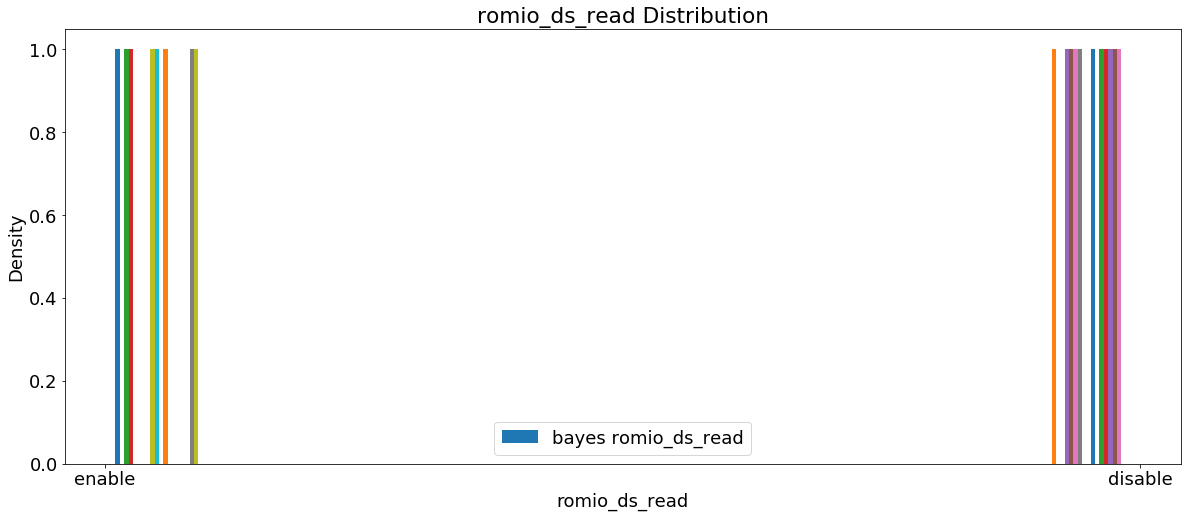

In [21]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

plt.hist(bayes_params['romio_ds_read'], label = 'bayes romio_ds_read', linewidth = 2)
#plt.hist(romio_ds_read_dist,color="red",linewidth=2, label = 'initial romio_ds_read')

plt.legend()
plt.xlabel('romio_ds_read'); plt.ylabel('Density'); plt.title('romio_ds_read Distribution');

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


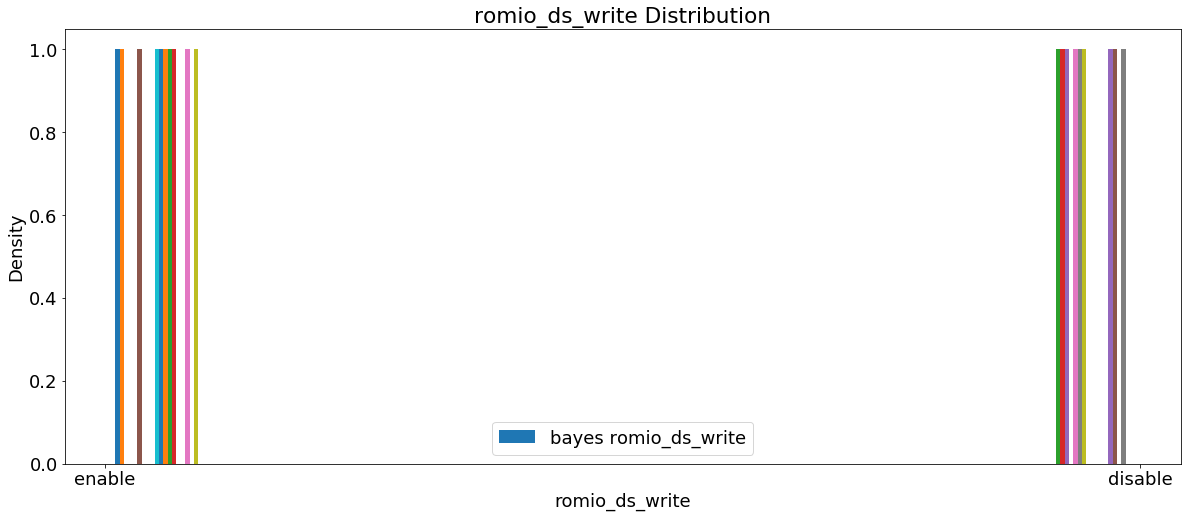

In [22]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

plt.hist(bayes_params['romio_ds_write'], label = 'bayes romio_ds_write', linewidth = 2)
#plt.hist(romio_ds_write_dist,color="red",linewidth=2, label = 'initial romio_ds_write')

plt.legend()
plt.xlabel('romio_ds_write'); plt.ylabel('Density'); plt.title('romio_ds_write Distribution');

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


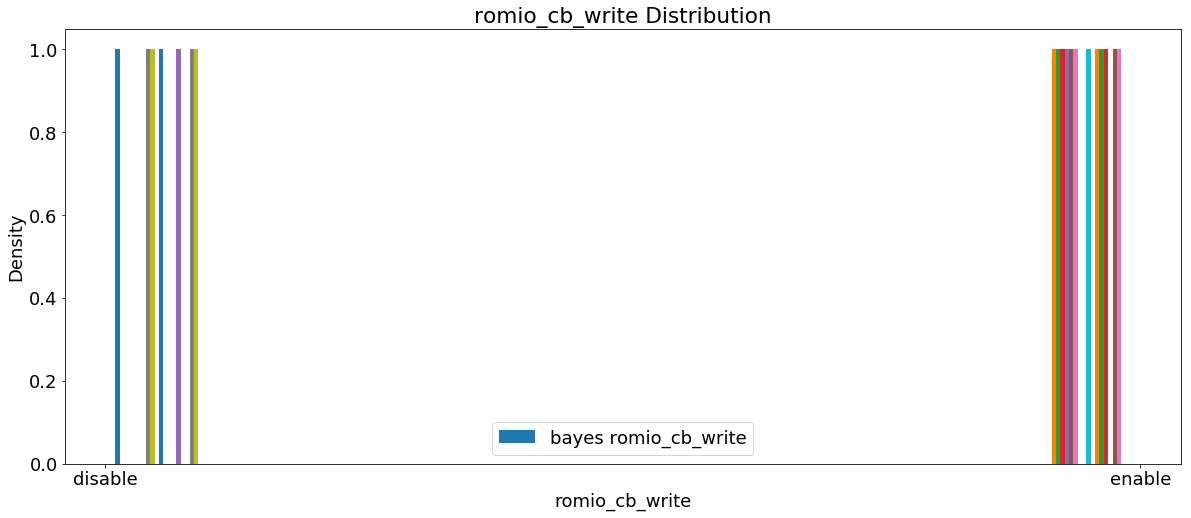

In [23]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

plt.hist(bayes_params['romio_cb_write'], label = 'bayes romio_cb_write', linewidth = 2)
#plt.hist(romio_ds_write_dist,color="red",linewidth=2, label = 'initial romio_cb_write')

plt.legend()
plt.xlabel('romio_cb_write'); plt.ylabel('Density'); plt.title('romio_cb_write Distribution');

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


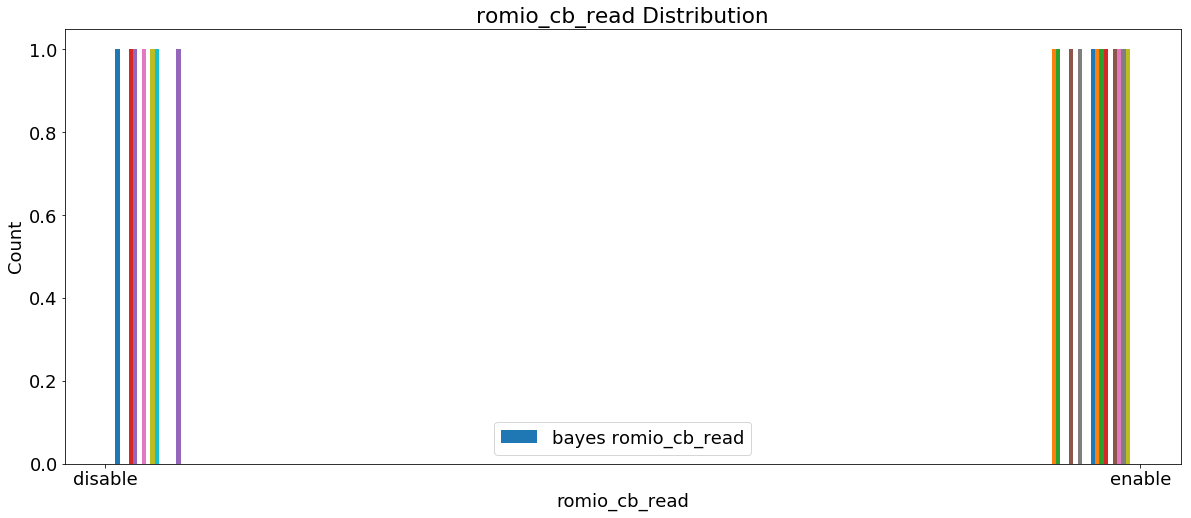

In [24]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

plt.hist(bayes_params['romio_cb_read'], label = 'bayes romio_cb_read', linewidth = 2)
#plt.hist(romio_cb_read_dist,color="red",linewidth=2, label = 'initial romio_cb_read')

plt.legend()
plt.xlabel('romio_cb_read'); plt.ylabel('Count'); plt.title('romio_cb_read Distribution');